In [1]:
# Using the UDPipe library via its Python binding.
# Source: http://ufal.mff.cuni.cz/udpipe
from ufal.udpipe import Model, Pipeline, InputFormat
import ufal.udpipe

import pandas as pd, matplotlib.pyplot as plt
import ahocorasick
import json

from collections import defaultdict, Counter
from wordcloud import WordCloud

# Loading the text.
output_all_chapters = './data/clean/svejk_chapters.jsonl'
all_chapters = []

with open(output_all_chapters, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f): # Each "line" is a block of chapter data.
        try:
            chapter = json.loads(line.strip())
            all_chapters.append(chapter)
        except json.JSONDecodeError as e:
            print(f"Warning: Could not decode JSON on line {line_num + 1}: {e}.")
            continue 

# Loading the locations names base.
output_base = './data/clean/geo_base.csv'

df_base = pd.read_csv(output_base)
df_base.set_index('municipality', inplace=True)
df_base.head()

,district
municipality,
Abertamy,['Ostrov']
Adamov,"['České Budějovice', 'Čáslav', 'Blansko']"
Adršpach,['Broumov']
Albertov,['Praha']
Albrechtice,"['Havířov', 'Lanškroun']"


In [2]:
# We use an older UDPipe 2.5 model for Czech. 
# See https://ufal.mff.cuni.cz/udpipe/2/models for more recent ones.

model = Model.load('czech-pdt-ud-2.5-191206.udpipe') # Source: http://hdl.handle.net/11234/1-3131

if model is None:
    raise Exception('Cannot load the UDPipe model.')

# Bringing up a UDPipe pipeline to tokenize and lemmatize.
udpipe_pipeline = Pipeline(model, 'tokenize', 'tag', Pipeline.DEFAULT, Pipeline.DEFAULT) 
#udpipe_pipeline = Pipeline(udpipe_model, 'tokenize', 'tag', 'parse', 'segment')

input_format = InputFormat.newInputFormat('conllu')
error = ufal.udpipe.ProcessingError()

# Some helper functions.

# Maps a word, as an instance of UDPipe.Word, to the triple (lemma, gender, plural flag). 
def word_to_triple(word):
    if word.form in CUSTOM_LEMMA:
        return CUSTOM_LEMMA[word.form]

    # Capitalization is retained. This helps to reduce (but not to eliminate entirely) false matches for the settlement names
    # that consist of a single adjective (e.g. Krásno, Krásna, Dobrá, Dobré).
    lemma = word.lemma
    if word.form.istitle() and word.upostag != 'PROPN':
        lemma = lemma.title()
        
    pos = word.feats.find('Gender=')
    gender = word.feats[pos + 7] if pos >= 0 else None # 7 == len('Gender=')

    return (lemma, gender, 'Number=Plur' in word.feats)

# Map each word in a sentence to the triple (lemma, gender, plural flag). 
# The argument can be a string or an instance of UDPipe.Sentence.
def lemmatize(sent):
    if isinstance(sent, str):
        processed_sent = udpipe_pipeline.process(sent)
        input_format.setText(processed_sent)

        sentence = ufal.udpipe.Sentence()
        res = []
        # Sometimes redundant sentence breaks appear, even when 'sent' is a single sentence (which is the indendent usage case).
        while input_format.nextSentence(sentence, error):
            model.tag(sentence, model.DEFAULT)
            model.parse(sentence, model.DEFAULT)
            res.extend(word_to_triple(word) for word in sentence.words if word.lemma[0].isalpha())
            sentence = ufal.udpipe.Sentence()
        if error.occurred():
            raise Exception(f'Error while reading a sentence: {error.message}')  
        return tuple(res)

    elif isinstance(sent, ufal.udpipe.Sentence):
        sentence = sent
    else:
        raise Exception(f'Cannot proceed with an argument of type {type(sent)}.')
        
    model.tag(sentence, model.DEFAULT)
    model.parse(sentence, model.DEFAULT)
    
    res = [word_to_triple(word) for word in sentence.words if word.lemma[0].isalpha()]

    return tuple(res)

# Map a triple (lemma, gender, plural flag) to a string.
def compress(triple):
    lemma, gender, plural_flag = triple
    if gender:
        return lemma + gender + str(int(plural_flag)) + '#'
    return lemma + '#'

# Given a list of tuples ((a, b), <data>), remove all such tuples where (a,b) is contained, as an interval, in (c,d)
# for some other ((c,d), <data>) in arr. This is used for greedy-matching.
def remove_inclusions(arr):
    res = [] 

    arr.sort(key=lambda x: x[0][1] - x[0][0], reverse=True)
    arr.sort()    
    cur_right = -1    
    for t in arr:
        (_, right), _ = t
        if right > cur_right:
            res.append(t)
            cur_right = right
            
    return res    

# Hard-coding some edge cases.
CUSTOM_LEMMA = {'Čím':      ('Čím', 'M', False), # There is a village named Čím (avoid lemmatizing it to 'co').
                'Ludvíkov': ('Ludvíkov', 'M', False),
                'Zlivi':    ('Zliv', 'M', False)} 

# Ignore false matches. What constitutes a "false match" is task- and context-dependent.
# In our case we have to take into account that there are Czech municipalities named 
# Vídeň, Uhersko, Srbsko, Srby etc. that trigger multiple matches in "Osudy...", 
# while not being the actual locations the author refers to (most likely). 
# A similar issue comes up for some personal names, nouns and adjectives.
IGNORE = {'Vídeň', 'Uhersko', 'Srbsko', 'Srby', 'Rusín', 'Čechy',
          'Jaroslav', 'Ludvík', 'Slavíkov', 'Dub',
          'Hosty', 'Kámen',
          'Bílá', 'Bystrá', 'Dobré', 'Dobrá', 'Milý', 'Svatá',
          'Čím'} 

ALIAS = {'Budějovice' : 'České Budějovice', # A choice made at the expense of missing possible references to Moravské Budějovice.
         'Bojiště': 'Praha', # Ulice Na Bojišti (in Prague) is a fairly important locality in the novel. 
                             # There are several other localities named Bojiště though.
         'Kralupy': 'Kralupy nad Vltavou'}

name_to_lemmata = {}
lemmata_to_name = defaultdict(lambda: [])
for name in df_base.index:
    lemmata = lemmatize(name)
    name_to_lemmata[name] = lemmata 
    lemmata_to_name[lemmata].append(name)

for lemmata, name in lemmata_to_name.items():
    if len(name) > 1:
        print (f'Collisions found: {name} -> {lemmata}')

for name in ALIAS:
    lemmata = lemmatize(name)
    name_to_lemmata[name] = lemmata
    lemmata_to_name[lemmata].append(ALIAS[name])

# The most common lemmata in our toponyms base.
unique_count = Counter(lemma for lemmata in name_to_lemmata.values() for lemma in lemmata)
unique_count.most_common(10), len(unique_count)

Collisions found: ['Březina', 'Březiny'] -> (('Březina', 'M', False),)
Collisions found: ['Džbán', 'Džbánov'] -> (('Džbán', 'M', False),)
Collisions found: ['Hlince', 'Hlinka'] -> (('Hlinka', 'M', False),)
Collisions found: ['Hradce', 'Hradec'] -> (('Hradec', 'M', False),)
Collisions found: ['Luby', 'Lubě'] -> (('Luba', 'F', True),)
Collisions found: ['Radkov', 'Radkovy'] -> (('Radkov', 'M', False),)


([(('nad', None, False), 197),
  (('u', None, False), 149),
  (('U', None, False), 96),
  (('Na', None, False), 60),
  (('Lhota', 'F', False), 54),
  (('pod', None, False), 53),
  (('Horní', 'F', False), 52),
  (('Dolní', 'F', False), 40),
  (('Horní', 'M', False), 38),
  (('Nový', 'F', False), 37)],
 5764)

In [3]:
# TEST1 = 'Kostel svatého Petra a Pavla v Kostomlatech pod Řípem v okrese Litoměřice je původně filiální římskokatolický kostel.'
# TEST2 = 'Jiřice u Moravských Budějovic je obec v České republice, malebně polożená na okraji přírodního parku Jevišovka. '
# TEST3 = 'Jednou v Mydlovarech u Zlivi, okres Hluboká, okresní hejtmanství České Budějovice, právě když jsme tam měli jednadevadesátí cvičení.'

# print (lemmatize(TEST1))

In [4]:
# Bringing up an Aho-Corasick automaton. The patterns to search for in the text are the lemmata patterns of the toponyms.
A = ahocorasick.Automaton()
index_to_lemmata = {}
length = {}
for index, lemmata in enumerate(lemmata_to_name.keys()):
    lemmata_compressed = ''.join(compress(triple) for triple in lemmata)
    A.add_word(lemmata_compressed, index)
    index_to_lemmata[index] = lemmata
    length[index] = len(lemmata_compressed)
A.make_automaton()

all_results = []
reference_counter = Counter()

# Iterating over chapters.
for chapter in all_chapters:
    chapter_text = chapter.get('chapter_text')
    
    # This is a container to hold the references found in a current chapter.    
    chapter_results = {key: value for key, value in chapter.items() if key != 'chapter_text'}
    chapter_results['sentence_matches'] = []
    
    processed_text = udpipe_pipeline.process(chapter_text)
    input_format.setText(processed_text)

    # Iterating over sentences.
    sentence = ufal.udpipe.Sentence()
    sentence_cnt = 0
    while input_format.nextSentence(sentence, error):
        sentence_cnt += 1
        compressed_sentence = ''.join(compress(triple) for triple in lemmatize(sentence))
        found_matches = [((end_pos - length[index] + 1, end_pos), index) for end_pos, index in A.iter(compressed_sentence)]
        found_matches = remove_inclusions(found_matches)        
        if found_matches:
            chapter_results['sentence_matches'].append({'sentence_id': sentence_cnt, 
                                                        'sentence_text': sentence.getText(),
                                                        'matches': []})        
            for _, index in found_matches:
                for name_found in lemmata_to_name[index_to_lemmata[index]]:
                    if name_found not in IGNORE:
                        chapter_results['sentence_matches'][-1]['matches'].append({'location:': name_found,
                                                                                   'metadata' : df_base.loc[name_found, 'district']}) 
                        reference_counter[name_found] += 1
                        
            # If there are no matches or all matches had to be ignored, do not include the sentence into the report.
            if not chapter_results['sentence_matches'][-1]['matches']:
                chapter_results['sentence_matches'].pop()                
        sentence = ufal.udpipe.Sentence()

    if error.occurred():
        raise Exception(f'An error while processing sentence {sentence_cnt}: {error.message}')
        
    all_results.append(chapter_results)
    print (f'{len(all_results)} chapter(s) processed. {reference_counter.total()} location references identified.')

output_jsonl_filename = './data/clean/svejk_geo_references.jsonl'
try:
    with open(output_jsonl_filename, 'w', encoding='utf-8') as f:
        for chapter_results in all_results:
            f.write(json.dumps(chapter_results, ensure_ascii=False) + '\n')
    print (f'The results are saved to "{output_jsonl_filename}" as JSONL.')
except Exception as e:
    print (f'Error saving JSONL: {e}')

1 chapter(s) processed. 4 location references identified.
2 chapter(s) processed. 7 location references identified.
3 chapter(s) processed. 9 location references identified.
4 chapter(s) processed. 12 location references identified.
5 chapter(s) processed. 20 location references identified.
6 chapter(s) processed. 25 location references identified.
7 chapter(s) processed. 30 location references identified.
8 chapter(s) processed. 35 location references identified.
9 chapter(s) processed. 38 location references identified.
10 chapter(s) processed. 58 location references identified.
11 chapter(s) processed. 66 location references identified.
12 chapter(s) processed. 68 location references identified.
13 chapter(s) processed. 75 location references identified.
14 chapter(s) processed. 108 location references identified.
15 chapter(s) processed. 114 location references identified.
16 chapter(s) processed. 145 location references identified.
17 chapter(s) processed. 288 location references 

Counter({'České Budějovice': 96, 'Praha': 62, 'Písek': 23, 'Černá': 17, 'Vršovice': 14, 'Tábor': 13, 'Luka': 11, 'Protivín': 10, 'Žižkov': 9, 'Karlín': 8, 'Strakonice': 8, 'Ostrov': 7, 'Malá Strana': 6, 'Most': 6, 'Kralupy nad Vltavou': 6, 'Kladno': 5, 'Milevsko': 5, 'Malčín': 5, 'Trutnov': 5, 'Karlík': 5, 'Nusle': 4, 'Krásná': 4, 'Kuklík': 4, 'Pelhřimov': 4, 'Květov': 4, 'Radomyšl': 4, 'Hájek': 4, 'Jindřichův Hradec': 4, 'Břevnov': 3, 'Libeň': 3, 'Josefov': 3, 'Smíchov': 3, 'Hradce': 3, 'Hradec': 3, 'Římov': 3, 'Vráž': 3, 'Horažďovice': 3, 'Pardubice': 3, 'Dolní Bousov': 3, 'Nepomuk': 3, 'Nové Město': 3, 'Zliv': 2, 'U soudu': 2, 'Brno': 2, 'Krakov': 2, 'Benešov': 2, 'Zderaz': 2, 'Bílá hora': 2, 'Havlíčkovo náměstí': 2, 'Bojiště': 2, 'Klatovy': 2, 'Plzeň': 2, 'Rybníček': 2, 'Hory': 2, 'Motol': 2, 'Benátky': 2, 'Poděbrady': 2, 'Kundratice': 2, 'Mnich': 1, 'Hluboká': 1, 'Račiněves': 1, 'Vodičkova': 1, 'Hranice': 1, 'Na Pankráci': 1, 'Merklín': 1, 'Nymburk': 1, 'Chodov': 1, 'Klamovka': 1,

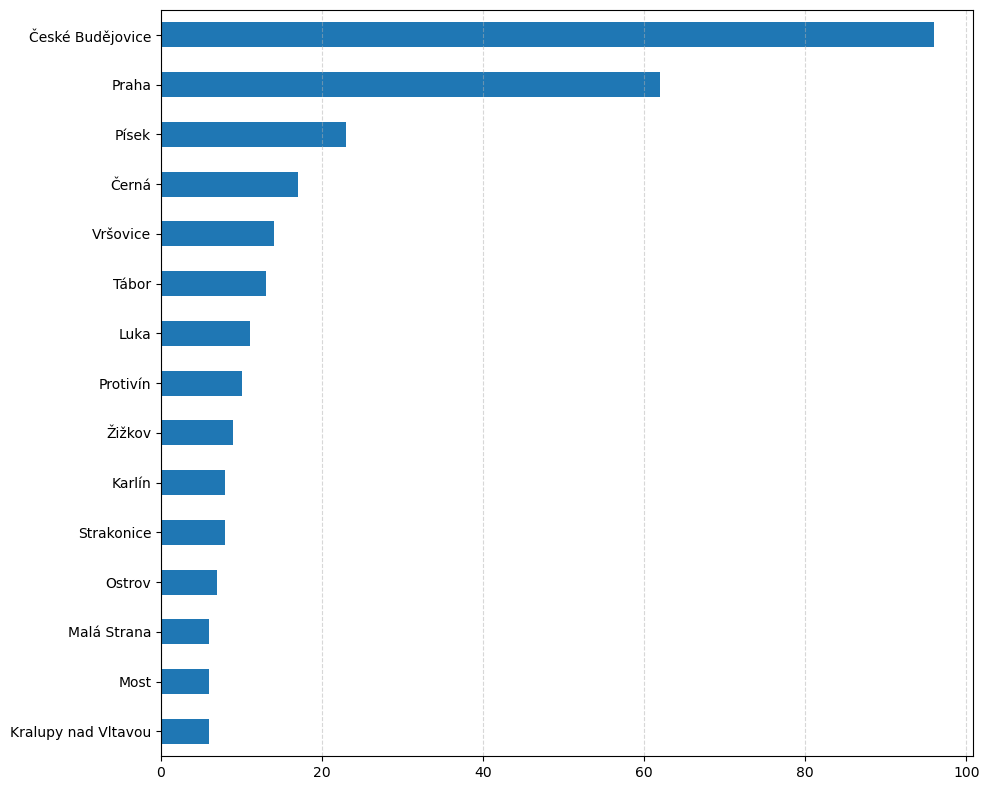

In [5]:
print(reference_counter, len(reference_counter))

n = 15
top_n = pd.Series(dict(reference_counter.most_common(n)))

plt.figure(figsize=(10,8))
top_n.plot(kind='barh')

plt.grid(axis='x', linestyle='--', alpha=0.5) 
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

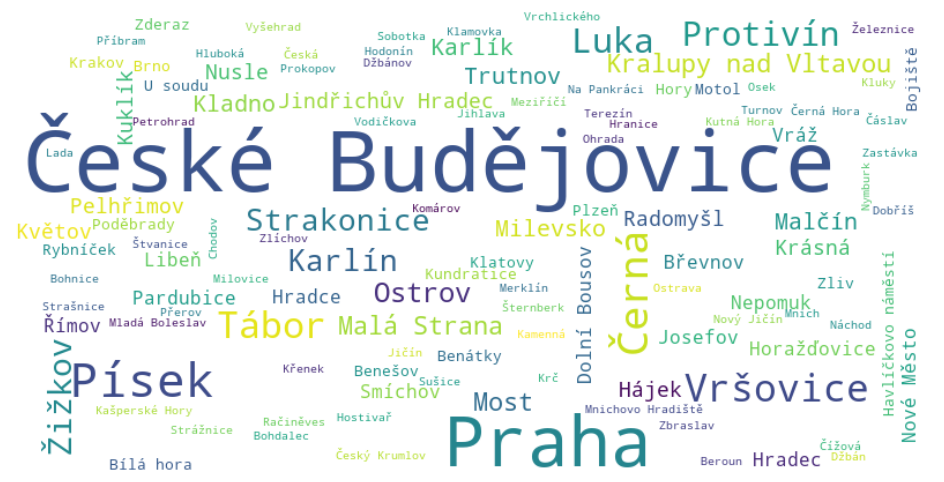

In [6]:
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    collocations=False,
    max_words=120,
    min_font_size=10,
    colormap='viridis'
)

wordcloud.generate_from_frequencies(reference_counter)

plt.figure(figsize=(12, 6)) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off')

plt.savefig('svejk-geo-wordcloud.png')
plt.show()
